### VaR Historical Simulation
The Historical Simulation Method entails calculating daily portfolio changes in value to determine the probability distribution of returns. It does that by looking at how your portfolio would have behaved historically.
Once you have your portfolio’s returns, or losses, you can calculate within a confidence interval the worst possible outcome.

Tutorial: https://towardsdatascience.com/learn-to-calculate-your-portfolios-value-at-risk-e1e2c5c68456

In [24]:
# Imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
import datetime as dt

# Display at most 10 rows
pd.set_option('display.max_rows', 10)


In [47]:
'''
User Set Up
'''

data = {'Stocks':['GOOGL', 'TSLA','AAPL'], 'Quantity':[100, 50, 300]} #Define your holdings
ScenariosNo = 1500 #Define the number of scenarios you want to run (i.e. # days looking back)
Percentile = 95 #Define your confidence interval
VarDaysHorizon = 50 #Define your time period
info = 1 #1 if you want more info returned by the script
today = dt.date.today() - dt.timedelta(days=1)

Tickers = []
for ticker in data['Stocks']:
    Tickers.append(ticker)
print(Tickers)

# Create a DataFrame of holdings
df = pd.DataFrame(data)
print('[INFO] Calculating the max amount of money the portfolio will lose within', VarDaysHorizon, 'days', Percentile, 'percent of the time.')

['GOOGL', 'TSLA', 'AAPL']
[INFO] Calculating the max amount of money the portfolio will lose within 50 days 95 percent of the time.


In [48]:
def SourceHistoricPrices():
    if info == 1: print('[INFO] Fetching stock prices for portfolio holdings')
    Tickers = []
    i=0
    for ticker in data:
        while i <= len(data):
            Tickers.append(data[ticker][i])
            i=i+1
    if info == 1: print('[INFO] Portfolio Holdings determined as', Tickers)
    if info == 1: print('[INFO] Portfolio Weights determined as', data['Quantity'])
    
    #Call the yFinance and store the data
    global HistData
    endDate =(dt.date.today() - dt.timedelta(days=ScenariosNo))
    HistData = yf.download("GOOGL TSLA AAPL", start =str(endDate), end =str(today))
    
    if info == 1: print('[INFO] Fetching stock prices completed.', len(HistData), 'days.')
    HistData= HistData['Adj Close']
    print('HistData: \n', HistData)
    return(HistData)

HistData = SourceHistoricPrices()

[INFO] Fetching stock prices for portfolio holdings
[INFO] Portfolio Holdings determined as ['GOOGL', 'TSLA', 'AAPL']
[INFO] Portfolio Weights determined as [100, 50, 300]
[*********************100%***********************]  3 of 3 completed
[INFO] Fetching stock prices completed. 1034 days.
HistData: 
                   AAPL        GOOGL        TSLA
Date                                           
2016-01-25   92.703934   733.619995  196.380005
2016-01-26   93.216660   733.789978  193.559998
2016-01-27   87.091728   717.580017  188.070007
2016-01-28   87.716331   748.299988  189.699997
2016-01-29   90.746178   761.349976  191.199997
...                ...          ...         ...
2020-02-26  292.649994  1390.469971  778.799988
2020-02-27  273.519989  1314.949951  679.000000
2020-02-28  273.359985  1339.250000  667.989990
2020-03-02  298.809998  1386.319946  743.619995
2020-03-03  289.320007  1337.719971  745.510010

[1034 rows x 3 columns]


In [49]:
def ValuePortfolio():
    if info == 1: print('[INFO] Calculating the portfolio value for each day')
    HistData['PortfolioValue'] = 0.0
    print('Tickers: ', Tickers)
    for i in range(len(HistData)):
        val = (HistData["AAPL"][i] * 300) + (HistData["GOOGL"][i] * 100) + (HistData["TSLA"][i] * 50)
        HistData['PortfolioValue'][i] = val
        
HistData.fillna(0, inplace = True)
ValuePortfolio()
print(HistData)

[INFO] Calculating the portfolio value for each day
Tickers:  ['GOOGL', 'TSLA', 'AAPL']
                  AAPL        GOOGL        TSLA  PortfolioValue
Date                                                           
2016-01-25   92.703934   733.619995  196.380005   110992.179871
2016-01-26   93.216660   733.789978  193.559998   111021.995544
2016-01-27   87.091728   717.580017  188.070007   107289.020538
2016-01-28   87.716331   748.299988  189.699997   110629.898071
2016-01-29   90.746178   761.349976  191.199997   112918.850708
...                ...          ...         ...             ...
2020-02-26  292.649994  1390.469971  778.799988   265781.994629
2020-02-27  273.519989  1314.949951  679.000000   247500.991821
2020-02-28  273.359985  1339.250000  667.989990   249332.495117
2020-03-02  298.809998  1386.319946  743.619995   265455.993652
2020-03-03  289.320007  1337.719971  745.510010   257843.499756

[1034 rows x 4 columns]


In [50]:
def CalculateVaR():
    if info == 1: print('[INFO] Calculating Daily % Changes')
    #calculating percentage change
    HistData['Perc_Change'] = HistData['PortfolioValue'].pct_change()
    #calculate money change based on current valuation
    HistData['DollarChange'] = HistData.loc[HistData.index.max()]['PortfolioValue'] * HistData['Perc_Change'] 
    if info == 1: print('[INFO] Picking', round(HistData.loc[HistData.index.max()]['PortfolioValue'],2),' value from ', HistData.index.max().strftime('%Y-%m-%d'), ' as the latest valuation to base the monetary returns')
    ValueLocForPercentile = round(len(HistData) * (1 - (Percentile / 100)))
    if info == 1: print('[INFO] Picking the', ValueLocForPercentile, 'th highest value')
    global SortedHistData
    SortedHistData = HistData.sort_values(by=['DollarChange'])
    if info == 1: print('[INFO] Sorting the results by highest max loss')
    VaR_Result = SortedHistData.iloc[ValueLocForPercentile + 1,len(SortedHistData.columns)-1] * np.sqrt(VarDaysHorizon)
    print('The portfolio\'s VaR is:', round(VaR_Result,2))

CalculateVaR()

[INFO] Calculating Daily % Changes
[INFO] Picking 257843.5  value from  2020-03-03  as the latest valuation to base the monetary returns
[INFO] Picking the 52 th highest value
[INFO] Sorting the results by highest max loss
The portfolio's VaR is: -41862.13


In [51]:
def CalculateES():
    ValueLocForPercentile = round(len(HistData) * (1 - (Percentile / 100)))
    ES_Result = round(SortedHistData['DollarChange'].head(ValueLocForPercentile).mean(axis=0),2) * np.sqrt(VarDaysHorizon)
    print('The portfolios\'s Expected Shortfall is', ES_Result)
    
CalculateES()

The portfolios's Expected Shortfall is -60722.58270236041


In [52]:
SourceHistoricPrices()
ValuePortfolio()
CalculateVaR()
CalculateES()

[INFO] Fetching stock prices for portfolio holdings
[INFO] Portfolio Holdings determined as ['GOOGL', 'TSLA', 'AAPL']
[INFO] Portfolio Weights determined as [100, 50, 300]
[*********************100%***********************]  3 of 3 completed
[INFO] Fetching stock prices completed. 1034 days.
HistData: 
                   AAPL        GOOGL        TSLA
Date                                           
2016-01-25   92.703934   733.619995  196.380005
2016-01-26   93.216660   733.789978  193.559998
2016-01-27   87.091728   717.580017  188.070007
2016-01-28   87.716331   748.299988  189.699997
2016-01-29   90.746178   761.349976  191.199997
...                ...          ...         ...
2020-02-26  292.649994  1390.469971  778.799988
2020-02-27  273.519989  1314.949951  679.000000
2020-02-28  273.359985  1339.250000  667.989990
2020-03-02  298.809998  1386.319946  743.619995
2020-03-03  289.320007  1337.719971  745.510010

[1034 rows x 3 columns]
[INFO] Calculating the portfolio value for each

C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  import sys


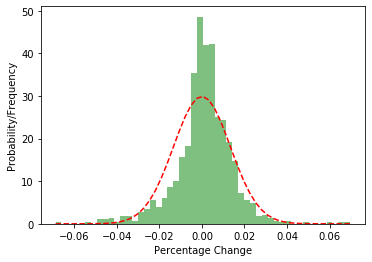

0.01333165742136395
0.0266633148427279


In [55]:
import scipy
import scipy.stats, matplotlib.pyplot as plt
def plotme():
    data1 = HistData['Perc_Change']
    num_bins = 50
    # the histogram of the data
    n, bins, patches = plt.hist(data1, num_bins, normed=1, facecolor='green', alpha=0.5)
    # add a 'best fit' line
    sigma = HistData['Perc_Change'].std()
    data2 = scipy.stats.norm.pdf(bins, 0, sigma)
    plt.plot(bins, data2, 'r--')
    plt.xlabel('Percentage Change')
    plt.ylabel('Probability/Frequency')
    # Tweak spacing to prevent clipping of ylabel
    plt.subplots_adjust(left=0.15)
    plt.show()
plotme()

st_d = np.std(HistData['Perc_Change'])
print(st_d)
st_d = 2 *st_d
print(st_d)